In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [75]:
# Generate synthetic Data set
dataset = np.random.uniform(low=0, high=50, size=(1000, 2))  # 50 random points in 2D space
# Query function: Euclidean distance between two points in 2D space
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2), ord=2)

In [76]:
def global_sensitivity(query, datapoints):
    max_sensitivity = 0
    for i in range(len(datapoints)):

        for j in range( 1, len(datapoints)):

            x = datapoints[i]
            # print('x',x)

            x0 = datapoints[j]
            # print(i,j)
            # print('x0',x0)
            if np.linalg.norm(np.array(x) - np.array(x0), ord=2) <= 2:
                sensitivity = abs(query(x, x0))
                max_sensitivity = max(max_sensitivity, sensitivity)
    return max_sensitivity

# Compute global sensitivity
sensitivity = global_sensitivity(euclidean_distance, dataset)
print("Global Sensitivity:", sensitivity)


Global Sensitivity: 1.9988231583829457


In [77]:
def original_distance(dataset,index):
  return [euclidean_distance(point, dataset[index])  for i, point in enumerate(dataset)]
original_dist=original_distance(dataset,index=1)


In [78]:
def old_laplace(dataset,epsilon,index):

  old_laplace=[]
  for point in dataset:
    laplace=euclidean_distance(point,dataset[index])+np.random.laplace(1/epsilon)
    old_laplace.append(laplace)

  return old_laplace

In [79]:
def new_laplace(dataset,epsilon,index):
  original_query=[euclidean_distance(point, dataset[index])  for i, point in enumerate(dataset)]
  new_laplace=[]
  sensitivity = global_sensitivity(euclidean_distance, dataset)
  for point in dataset:

    noise=np.random.laplace(scale=sensitivity / epsilon)
    dist=euclidean_distance(point,dataset[index])+noise
    new_laplace.append(dist)
  return new_laplace

In [80]:
# epsilon=0.5
# fixed_point=0
# new_laplace(dataset,epsilon,fixed_point)

In [81]:
#Mwem mechanism:
def distances_bw_points(data, fixed_point):
    distances = [euclidean_distance(point, fixed_point) for point in data]
    return distances

def utility_function(distances, private_distance):
    # Utility function: penalize large differences between original and perturbed distances
    return np.max(np.abs(np.array(distances) - np.array(private_distance)))

def exponential_mechanism(distances, epsilon):
    # Exponential mechanism for selecting outputs based on utility and adding Laplace noise for privacy
    utilities_sensitivity = [np.exp(-epsilon * utility) for utility in distances]
    probabilities = utilities_sensitivity / np.sum(utilities_sensitivity)
    selected_index = np.random.choice(len(distances), p=probabilities)
    return selected_index

def add_noise(distances, epsilon):
    # Add Laplace noise to distances for differential privacy
    noisy_distances = [distance + np.random.laplace(scale=1/epsilon) for distance in distances]
    return noisy_distances

def mwem(data, epsilon, fixed_point):
    # Compute distances between data points and the fixed point
    distances = distances_bw_points(data, fixed_point)
    weighted_distances=[]
    utility_scores = [utility_function(distances, [distance]) for distance in distances]

    # Exponential mechanism: select output (perturbed distances) based on utility
    for i in range(len(data)):

      selected_index = exponential_mechanism(utility_scores, epsilon)
      # print(selected_index)
      private_distance = [distances[selected_index]]

    # Add Laplace noise to perturbed distances for differential privacy
      noisy_dist = add_noise(private_distance, epsilon)
      weighted_distances.append(noisy_dist[0])

    return weighted_distances

In [82]:
original_dataset=dataset

In [83]:
epsilon=0.5
fixed_point=0
dataset=original_dataset
original_value=original_distance(dataset,fixed_point)
mwem_dist=mwem(dataset,epsilon,fixed_point)
old_lap_dist=old_laplace(dataset,epsilon,fixed_point)
new_lap_dist=new_laplace(dataset,epsilon,fixed_point)
print(len(new_lap_dist))
rmse_new_lap=0
rmse_old_lap=0
rmse_mwem=0
n=len(original_value)
for i in range(len(original_value)):
  error1=(original_value[i]-new_lap_dist[i])**2
  error2=(original_value[i]-old_lap_dist[i])**2
  error3=(original_value[i]-mwem_dist[i])**2
  rmse_new_lap+=error1
  rmse_old_lap+=error2
  rmse_mwem+=error3
mse_new_lap=np.sqrt(rmse_new_lap)/n
mse_old_lap=np.sqrt(rmse_old_lap)/n
mse_mwem=np.sqrt(rmse_mwem)/n
print('rmse old laplace',mse_new_lap)
print('rmse new laplace',mse_old_lap)
print('rmse mwem ',mse_mwem)


1000
rmse old laplace 0.18273360752853518
rmse new laplace 0.07669496617573852
rmse mwem  0.5520850538066008


In [84]:
data=pd.read_csv('uscities.csv')
data.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18908608,11080.3,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,11922389,3184.7,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8497759,4614.5,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6080145,4758.9,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Houston,Houston,TX,Texas,48201,Harris,29.7860,-95.3885,5970127,1384.0,shape,False,True,America/Chicago,1,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925


In [85]:
df=pd.DataFrame(zip(data['lat'],data['lng']))
df[0][1]

34.1141

In [86]:
print(len(df))
dataset_original=[]
for i in range(len(df)):
  lat=df[0][i]
  lng=df[1][i]
  dataset_original.append([lat,lng])
dataset=dataset_original[:1000]
len(dataset)

31120


1000

In [87]:
epsilon=0.5
fixed_point=0

original_value=original_distance(dataset,fixed_point)
mwem_dist=mwem(dataset,epsilon,fixed_point)
old_lap_dist=old_laplace(dataset,epsilon,fixed_point)
new_lap_dist=new_laplace(dataset,epsilon,fixed_point)
print(len(new_lap_dist))
rmse_new_lap=0
rmse_old_lap=0
rmse_mwem=0
n=len(original_value)
for i in range(len(original_value)):
  error1=(original_value[i]-new_lap_dist[i])**2
  error2=(original_value[i]-old_lap_dist[i])**2
  error3=(original_value[i]-mwem_dist[i])**2
  rmse_new_lap+=error1
  rmse_old_lap+=error2
  rmse_mwem+=error3
mse_new_lap=np.sqrt(rmse_new_lap)/n
mse_old_lap=np.sqrt(rmse_old_lap)/n
mse_mwem=np.sqrt(rmse_mwem)/n
print('rmse old laplace',mse_new_lap)
print('rmse new laplace',mse_old_lap)
print('rmse mwem ',mse_mwem)

1000
rmse old laplace 0.16956794550085535
rmse new laplace 0.07798044656093918
rmse mwem  2.9546171863443935


In [88]:

def dx_ij(lst):
  ui=lst[0][0]
  vi=lst[0][1]
  uj=lst[1][0]
  vj=lst[1][1]
  dx=np.sqrt((ui-uj)**2+(vi-vj)**2)
  return dx

def laplace_blow(dataset,epsilon,fixed_point,T):
  noise_query=[]
  sensitivity = global_sensitivity(euclidean_distance, dataset)
  for point in dataset:
    dx=dx_ij([dataset[fixed_point],point])
    # print(dx)
    if dx<=T:
      dx_blow=epsilon

    else :
      dx_blow=np.inf
    # print(epsilon)
    noise=np.random.laplace(scale=sensitivity / dx_blow)

    dist=euclidean_distance(point,dataset[fixed_point])+noise#adding laplace noise using defination of senstivity
    # print(dist)

    # print(dist)
    noise_query.append(dist)
  return noise_query

In [89]:
def laplace_smooth(dataset,epsilon,fixed_point,T):
  noise_query=[]
  for point in dataset:
    dx=euclidean_distance(dataset[fixed_point],point)

    #print(dx)
    if dx<=T:
      dx_smooth=epsilon

    else :
      dx_smooth=(epsilon*dx)/T
    # print(epsilon)
    noise=np.random.laplace(scale=sensitivity / dx_smooth)
    dist=euclidean_distance(point,dataset[fixed_point])+noise#adding laplace noise using defination of senstivity
    # print(dist)
    # print(noise)
    # print(dist)
    noise_query.append(dist)
  return noise_query

In [90]:
eosilon=0.5
T=2
fixed_point=0
blow_dist=laplace_blow(dataset,epsilon,fixed_point,T)
smooth_dist=laplace_smooth(dataset,epsilon,fixed_point,T)


rmse_blow=0
rmse_smooth=0

n=len(original_value)
for i in range(len(original_value)):
  error4=(original_value[i]-blow_dist[i])**2
  error5=(original_value[i]-smooth_dist[i])**2
  rmse_blow+=error4
  rmse_smooth+=error5
mse_blow=np.sqrt(rmse_blow)/n
mse_smooth=np.sqrt(rmse_smooth)/n

print('rmse laplace blowfish',mse_blow)
print('rmse laplace smooth',mse_smooth)

rmse laplace blowfish 0.03400512255489986
rmse laplace smooth 0.056413222278244225


In [91]:
dataset=original_dataset[0:1000]
T=[2,4,6,16]
epsilon=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
fixed_point=0
original_value=original_distance(dataset,fixed_point)

rmse_values_blow=[]
rmse_values_smooth=[]
for t in T:
  rmse_for_t_blow=[]
  rmse_for_t_smooth=[]
  for ep in epsilon:

    blow_dist=laplace_blow(dataset,ep,fixed_point,t)
    smooth_dist=laplace_smooth(dataset,ep,fixed_point,t)
    rmse_laplace=0
    rmse_blow=0
    rmse_smooth=0

    n=len(original_value)
    for i in range(len(original_value)):
      error4=(original_value[i]-blow_dist[i])**2
      error5=(original_value[i]-smooth_dist[i])**2
      rmse_blow+=error4
      rmse_smooth+=error5
    mse_blow=np.sqrt(rmse_blow)/n
    mse_smooth=np.sqrt(rmse_smooth)/n
    rmse_for_t_blow.append(mse_blow)
    rmse_for_t_smooth.append(mse_smooth)
  rmse_values_blow.append(rmse_for_t_blow)
  rmse_values_smooth.append(rmse_for_t_smooth)
rmse_values_lap=[]
for ep in epsilon:

    laplace=new_laplace(dataset,ep,fixed_point)
    rmse_laplace=0


    n=len(original_value)
    for i in range(len(original_value)):

      error6=(original_value[i]-laplace[i])**2
      rmse_laplace+=error6
    mse_lap=np.sqrt(rmse_laplace)/n
    rmse_values_lap.append(mse_lap)

In [92]:
rmse_values_lap


[0.914833045625222,
 0.4304914955282213,
 0.31352242753557286,
 0.22284007358804858,
 0.18109366337347402,
 0.1525850514481848,
 0.12609183007814867,
 0.10808857649307899,
 0.09500494505379839,
 0.08894251414834725]

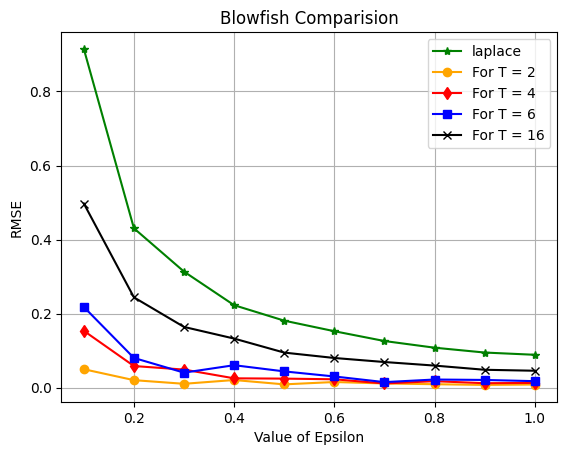

In [93]:
# Plot the dx Blowfish


plt.plot(epsilon,rmse_values_lap, label='laplace', color='green', marker='*')
plt.plot(epsilon,rmse_values_blow[0], label=f'For T = {T[0]}', color='orange', marker='o')
plt.plot(epsilon,rmse_values_blow[1], label=f'For T = {T[1]}', color='red', marker='d')
plt.plot(epsilon,rmse_values_blow[2], label=f'For T = {T[2]}', color='blue', marker='s')
plt.plot(epsilon,rmse_values_blow[3], label=f'For T = {T[3]}', color='black', marker='x')



plt.xlabel('Value of Epsilon')
plt.ylabel('RMSE')
plt.title('Blowfish Comparision')

# Add legend
plt.legend()
plt.grid()
# Show plot
plt.show()

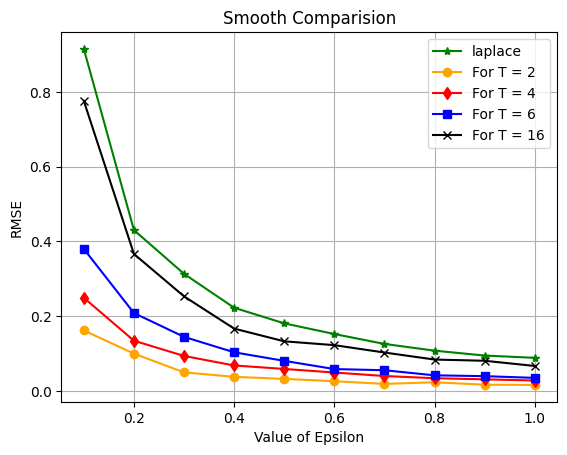

In [94]:
# Plot Smooth
# plt.figure(figsize=(10,8))
# for i in range(len(T)):

plt.plot(epsilon,rmse_values_lap, label='laplace', color='green', marker='*')
plt.plot(epsilon,rmse_values_smooth[0], label=f'For T = {T[0]}', color='orange', marker='o')
plt.plot(epsilon,rmse_values_smooth[1], label=f'For T = {T[1]}', color='red', marker='d')
plt.plot(epsilon,rmse_values_smooth[2], label=f'For T = {T[2]}', color='blue', marker='s')
plt.plot(epsilon,rmse_values_smooth[3], label=f'For T = {T[3]}', color='black', marker='x')



plt.xlabel('Value of Epsilon')
plt.ylabel('RMSE')
plt.title('Smooth Comparision')

# Add legend
plt.legend()
plt.grid()
# Show plot
plt.show()


In [95]:
dataset = np.random.uniform(low=0, high=50, size=(1000, 2))

In [96]:

T=[2,4,8,16]
epsilon=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
fixed_point=0
original_value=original_distance(dataset,fixed_point)

rmse_values_blow=[]
rmse_values_smooth=[]
for t in T:
  rmse_for_t_blow=[]
  rmse_for_t_smooth=[]
  for ep in epsilon:

    blow_dist=laplace_blow(dataset,ep,fixed_point,t)
    smooth_dist=laplace_smooth(dataset,ep,fixed_point,t)
    rmse_laplace=0
    rmse_blow=0
    rmse_smooth=0

    n=len(original_value)
    for i in range(len(original_value)):
      error4=(original_value[i]-blow_dist[i])**2
      error5=(original_value[i]-smooth_dist[i])**2
      rmse_blow+=error4
      rmse_smooth+=error5
    mse_blow=np.sqrt(rmse_blow)/n
    mse_smooth=np.sqrt(rmse_smooth)/n
    rmse_for_t_blow.append(mse_blow)
    rmse_for_t_smooth.append(mse_smooth)
  rmse_values_blow.append(rmse_for_t_blow)
  rmse_values_smooth.append(rmse_for_t_smooth)
rmse_values_lap=[]
for ep in epsilon:

    laplace=new_laplace(dataset,ep,fixed_point)
    rmse_laplace=0


    n=len(original_value)
    for i in range(len(original_value)):

      error6=(original_value[i]-laplace[i])**2
      rmse_laplace+=error6
    mse_lap=np.sqrt(rmse_laplace)/n
    rmse_values_lap.append(mse_lap)



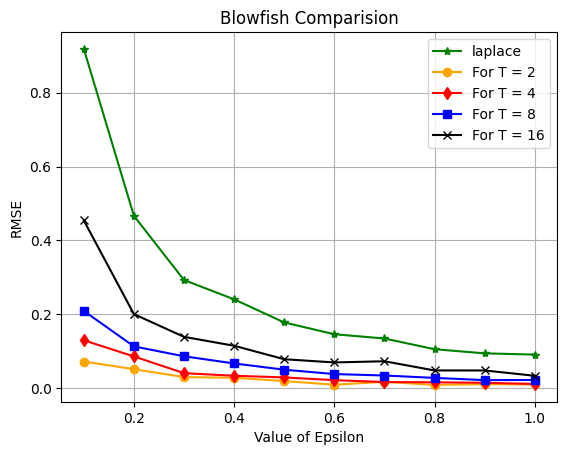

In [97]:
# Plot the dx Blowfish


plt.plot(epsilon,rmse_values_lap, label='laplace', color='green', marker='*')
plt.plot(epsilon,rmse_values_blow[0], label=f'For T = {T[0]}', color='orange', marker='o')
plt.plot(epsilon,rmse_values_blow[1], label=f'For T = {T[1]}', color='red', marker='d')
plt.plot(epsilon,rmse_values_blow[2], label=f'For T = {T[2]}', color='blue', marker='s')
plt.plot(epsilon,rmse_values_blow[3], label=f'For T = {T[3]}', color='black', marker='x')



plt.xlabel('Value of Epsilon')
plt.ylabel('RMSE')
plt.title('Blowfish Comparision')

# Add legend
plt.legend()
plt.grid()
# Show plot
plt.show()

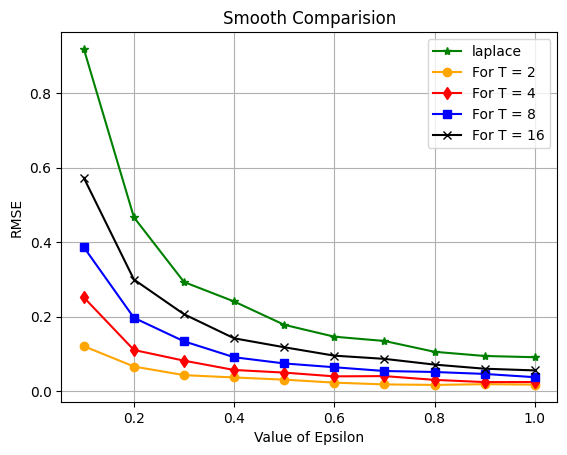

In [98]:
# Plot Smooth
# plt.figure(figsize=(10,8))
# for i in range(len(T)):

plt.plot(epsilon,rmse_values_lap, label='laplace', color='green', marker='*')
plt.plot(epsilon,rmse_values_smooth[0], label=f'For T = {T[0]}', color='orange', marker='o')
plt.plot(epsilon,rmse_values_smooth[1], label=f'For T = {T[1]}', color='red', marker='d')
plt.plot(epsilon,rmse_values_smooth[2], label=f'For T = {T[2]}', color='blue', marker='s')
plt.plot(epsilon,rmse_values_smooth[3], label=f'For T = {T[3]}', color='black', marker='x')



plt.xlabel('Value of Epsilon')
plt.ylabel('RMSE')
plt.title('Smooth Comparision')

# Add legend
plt.legend()
plt.grid()
# Show plot
plt.show()

In [99]:
# fixing the epsilon=1 for all values of T and finding rmse value
T=[2,4,8,16]
epsilon=[1]#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
fixed_point=0
original_value=original_distance(dataset,fixed_point)

rmse_values_blow=[]
rmse_values_smooth=[]
for t in T:
  rmse_for_t_blow=[]
  rmse_for_t_smooth=[]
  for ep in epsilon:

    blow_dist=laplace_blow(dataset,ep,fixed_point,t)
    smooth_dist=laplace_smooth(dataset,ep,fixed_point,t)
    rmse_laplace=0
    rmse_blow=0
    rmse_smooth=0

    n=len(original_value)
    for i in range(len(original_value)):
      error4=(original_value[i]-blow_dist[i])**2
      error5=(original_value[i]-smooth_dist[i])**2
      rmse_blow+=error4
      rmse_smooth+=error5
    mse_blow=np.sqrt(rmse_blow)/n
    mse_smooth=np.sqrt(rmse_smooth)/n
    rmse_for_t_blow.append(mse_blow)
    rmse_for_t_smooth.append(mse_smooth)
  rmse_values_blow.append(rmse_for_t_blow)
  rmse_values_smooth.append(rmse_for_t_smooth)
rmse_values_lap=[]
for ep in epsilon:

    laplace=new_laplace(dataset,ep,fixed_point)
    rmse_laplace=0


    n=len(original_value)
    for i in range(len(original_value)):

      error6=(original_value[i]-laplace[i])**2
      rmse_laplace+=error6
    mse_lap=np.sqrt(rmse_laplace)/n
    rmse_values_lap.append(mse_lap)


In [100]:
rmse_values_smooth

[[0.012394786696827642],
 [0.021808013097042642],
 [0.03869811373497274],
 [0.05842030595426225]]

In [101]:
rmse_values_blow

[[0.007216776182379763],
 [0.0126558343444036],
 [0.022100022919027042],
 [0.041282093213316357]]

In [102]:
from tabulate import tabulate

def create_table(data1, data2, data3):
    table = []
    for i, (item1, item2, item3) in enumerate(zip(data1, data2, data3), start=1):
        table.append([i, item1, item2, item3])
    return table

table_data = create_table(T,rmse_values_blow, rmse_values_smooth)
headers = ["Sr No",'Value_of_T', "dx-BlowFish", "dx-Smooth"]

print(tabulate(table_data, headers=headers, tablefmt="pretty"))

+-------+------------+------------------------+------------------------+
| Sr No | Value_of_T |      dx-BlowFish       |       dx-Smooth        |
+-------+------------+------------------------+------------------------+
|   1   |     2      | [0.007216776182379763] | [0.012394786696827642] |
|   2   |     4      |  [0.0126558343444036]  | [0.021808013097042642] |
|   3   |     8      | [0.022100022919027042] | [0.03869811373497274]  |
|   4   |     16     | [0.041282093213316357] | [0.05842030595426225]  |
+-------+------------+------------------------+------------------------+


In [105]:
#Fixing the T and taking different epsilon for comparing all the algorithm :
T=2
fixed_point=0
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

rmse_new_algo=[]
rmse_mwem_algo=[]
rmse_old_algo=[]
rmse_blow_algo=[]
rmse_smooth_algo=[]
for epsilon in epsilon_list:
  original_value=original_distance(dataset,fixed_point)
  mwem_dist=mwem(dataset,epsilon,fixed_point)
  old_lap_dist=old_laplace(dataset,epsilon,fixed_point)
  new_lap_dist=new_laplace(dataset,epsilon,fixed_point)
  # print(len(new_lap_dist))

  rmse_new_lap=0
  rmse_old_lap=0
  rmse_mwem=0

  n=len(original_value)
  for i in range(len(original_value)):
    error1=(original_value[i]-new_lap_dist[i])**2
    error2=(original_value[i]-old_lap_dist[i])**2
    error3=(original_value[i]-mwem_dist[i])**2
    rmse_new_lap+=error1
    rmse_old_lap+=error2
    rmse_mwem+=error3
  mse_new_lap=np.sqrt(rmse_new_lap)/n
  mse_old_lap=np.sqrt(rmse_old_lap)/n
  mse_mwem=np.sqrt(rmse_mwem)/n
  # print('rmse old laplace',mse_new_lap)
  # print('rmse new laplace',mse_old_lap)
  # print('rmse mwem ',mse_mwem)
  rmse_old_algo.append(mse_old_lap)
  rmse_new_algo.append(mse_new_lap)
  rmse_mwem_algo.append(mse_mwem)
  blow_dist=laplace_blow(dataset,epsilon,fixed_point,T)
  smooth_dist=laplace_smooth(dataset,epsilon,fixed_point,T)


  rmse_blow=0
  rmse_smooth=0

  n=len(original_value)
  for i in range(len(original_value)):
    error4=(original_value[i]-blow_dist[i])**2
    error5=(original_value[i]-smooth_dist[i])**2
    rmse_blow+=error4
    rmse_smooth+=error5
  mse_blow=np.sqrt(rmse_blow)/n
  mse_smooth=np.sqrt(rmse_smooth)/n

  rmse_blow_algo.append(mse_blow)
  rmse_smooth_algo.append(mse_smooth)


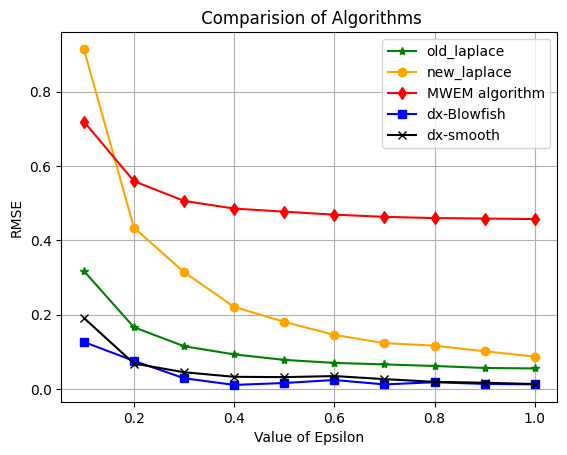

In [108]:
#plotting all algorithm together
plt.plot(epsilon_list,rmse_old_algo, label='old_laplace', color='green', marker='*')
plt.plot(epsilon_list,rmse_new_algo, label=f'new_laplace', color='orange', marker='o')
plt.plot(epsilon_list,rmse_mwem_algo, label=f'MWEM algorithm', color='red', marker='d')
plt.plot(epsilon_list,rmse_blow_algo, label=f'dx-Blowfish', color='blue', marker='s')
plt.plot(epsilon_list,rmse_smooth_algo, label=f'dx-smooth', color='black', marker='x')



plt.xlabel('Value of Epsilon')
plt.ylabel('RMSE')
plt.title(' Comparision of Algorithms')

# Add legend
plt.legend()
plt.grid()
# Show plot
plt.show()